In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import scipy.stats as sps

sns.set()


In [2]:
df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=range(8),encoding='UTF-8')
print (df.sum())
df

DagMånad     1 januari2 januari3 januari4 januari5 januari6...
2015                                                     89947
2016                                                     89019
2017                                                     89742
2018                                                     89672
2019                                                     86150
2020                                                     51557
2015-2019                                                89105
dtype: object


,DagMånad,2015,2016,2017,2018,2019,2020,2015-2019
0,1 januari,295,245,339,275,300,254,291
1,2 januari,272,272,317,312,276,300,290
2,3 januari,281,293,310,295,271,256,290
3,4 januari,256,260,305,285,282,272,278
4,5 januari,268,260,304,291,275,265,280
...,...,...,...,...,...,...,...,...
361,27 december,227,249,271,240,238,0,245
362,28 december,274,262,273,261,215,0,257
363,29 december,292,274,276,263,244,0,270
364,30 december,283,307,275,232,226,0,265


In [3]:
dates = pd.date_range('2020-01-01','2020-12-31')
df.set_index(dates,inplace=True)
df.loc['2020-02-25' : '2020-03-02']

mean = df['2015-2019'].mean()
std = df['2015-2019'].std()
print (mean,std)
print (df.sum())
print (df[['2015','2019']].sum().max() - df[['2015-2019']].sum().min())


243.45628415300547 22.23392450192705
DagMånad     1 januari2 januari3 januari4 januari5 januari6...
2015                                                     89947
2016                                                     89019
2017                                                     89742
2018                                                     89672
2019                                                     86150
2020                                                     51557
2015-2019                                                89105
dtype: object
842


88906.0
1579.3699693232109
[88430.    89386.055]
956.054999999993
88906.6043
298.6537347858051


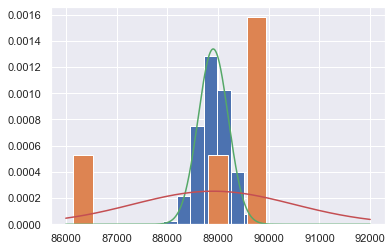

In [4]:
# random variability 954 vs diff max-min 842 vs 2020 y2d excess 2300
yearly_mean = df.loc[:,'2015' : '2019'].sum().mean()
print (yearly_mean)
yearly_std = df.loc[:,'2015' : '2019'].sum().std()
print (yearly_std)

samples = pm.rpoisson(yearly_mean,size=100000)
ci = np.percentile(samples,[5.5,94.5])
print (ci)
print (ci[1] - ci[0])
samples_mean = samples.mean()
samples_std = samples.std()

print (samples_mean)
print (samples_std)
plt.hist(samples,density=True)
plt.hist(df.loc[:,'2015':'2019'].sum(),density=True)

x = np.arange(86000,92000)
y = sps.poisson.pmf(x,mu=yearly_mean)
plt.plot(x,y)

y = sps.norm.pdf(x,yearly_mean,yearly_std)
plt.plot(x,y)


243.45628415300547 22.23392450192705


(array([0.00022124, 0.00168142, 0.007     , 0.01799115, 0.02474336,
        0.02123894, 0.01139823, 0.00326549, 0.00083186, 0.00012389]),
 array([190. , 201.3, 212.6, 223.9, 235.2, 246.5, 257.8, 269.1, 280.4,
        291.7, 303. ]),
 <a list of 10 Patch objects>)

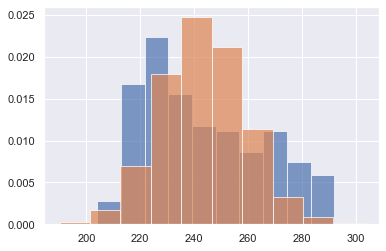

In [5]:
daily_mean = df['2015-2019'].mean()
daily_std = df['2015-2019'].std()

print (daily_mean,daily_std)
plt.hist(df['2015-2019'],density=True,alpha=0.7)

daily_samples = pm.rpoisson(daily_mean,10000)
plt.hist(daily_samples,density=True,alpha=0.7)

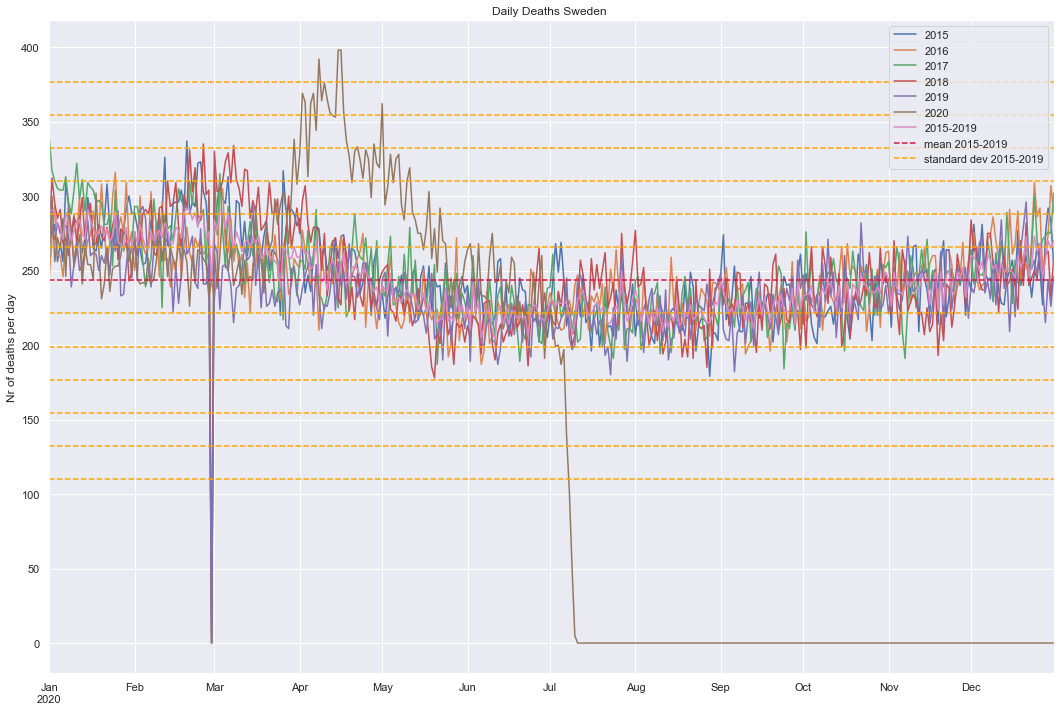

In [6]:
df.plot(figsize=(18,12))
plt.title('Daily Deaths Sweden ')
plt.axhline(mean,ls='dashed',color='crimson',label='mean 2015-2019')
plt.axhline(mean + std,ls='dashed',color='orange',label='standard dev 2015-2019')
plt.axhline(mean - std,ls='dashed',color='orange')
plt.axhline(mean + 2 * std,ls='dashed',color='orange')
plt.axhline(mean - 2 * std,ls='dashed',color='orange')
plt.axhline(mean + 3 * std,ls='dashed',color='orange')
plt.axhline(mean - 3 * std,ls='dashed',color='orange')
plt.axhline(mean + 4 * std,ls='dashed',color='orange')
plt.axhline(mean - 4 * std,ls='dashed',color='orange')
plt.axhline(mean + 5 * std,ls='dashed',color='orange')
plt.axhline(mean - 5 * std,ls='dashed',color='orange')
plt.axhline(mean + 6 * std,ls='dashed',color='orange')
plt.axhline(mean - 6 * std,ls='dashed',color='orange')
plt.ylabel('Nr of deaths per day')

plt.legend(loc='upper right')


Text(0.5, 1.0, '2020')

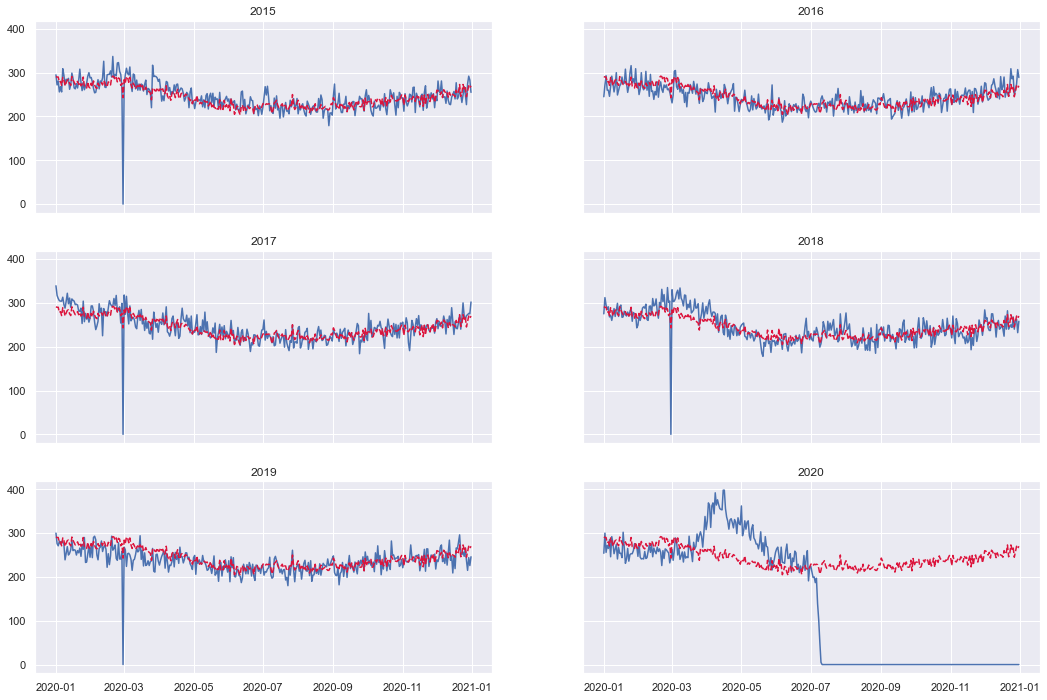

In [7]:
fig,axes = plt.subplots(3,2,sharex=True,sharey=True,figsize=(18,12))

axes[0,0].plot(df['2015'])
axes[0,0].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[0,0].set_title('2015')

axes[0,1].plot(df['2016'])
axes[0,1].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[0,1].set_title('2016')

axes[1,0].plot(df['2017'])
axes[1,0].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[1,0].set_title('2017')

axes[1,1].plot(df['2018'])
axes[1,1].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[1,1].set_title('2018')

axes[2,0].plot(df['2019'])
axes[2,0].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[2,0].set_title('2019')

axes[2,1].plot(df['2020'])
axes[2,1].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[2,1].set_title('2020')


Text(0, 0.5, 'total number of deaths')

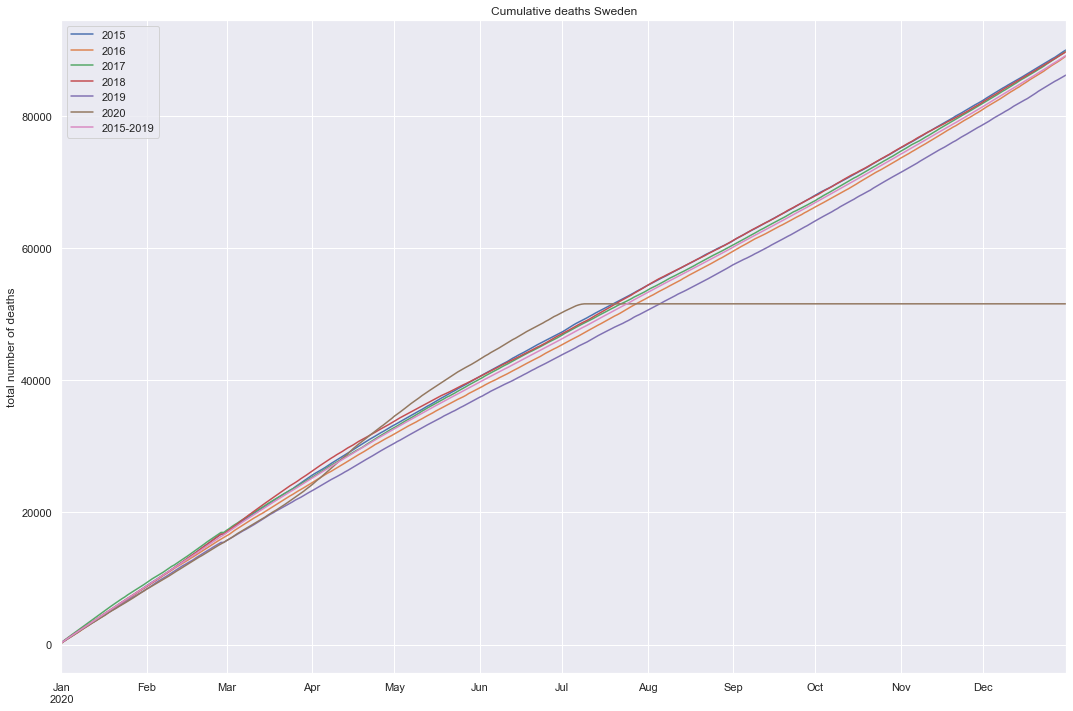

In [8]:
df.cumsum().plot(figsize=(18,12))
plt.title ('Cumulative deaths Sweden')
plt.ylabel('total number of deaths')

Text(0.5, 1.0, '2020')

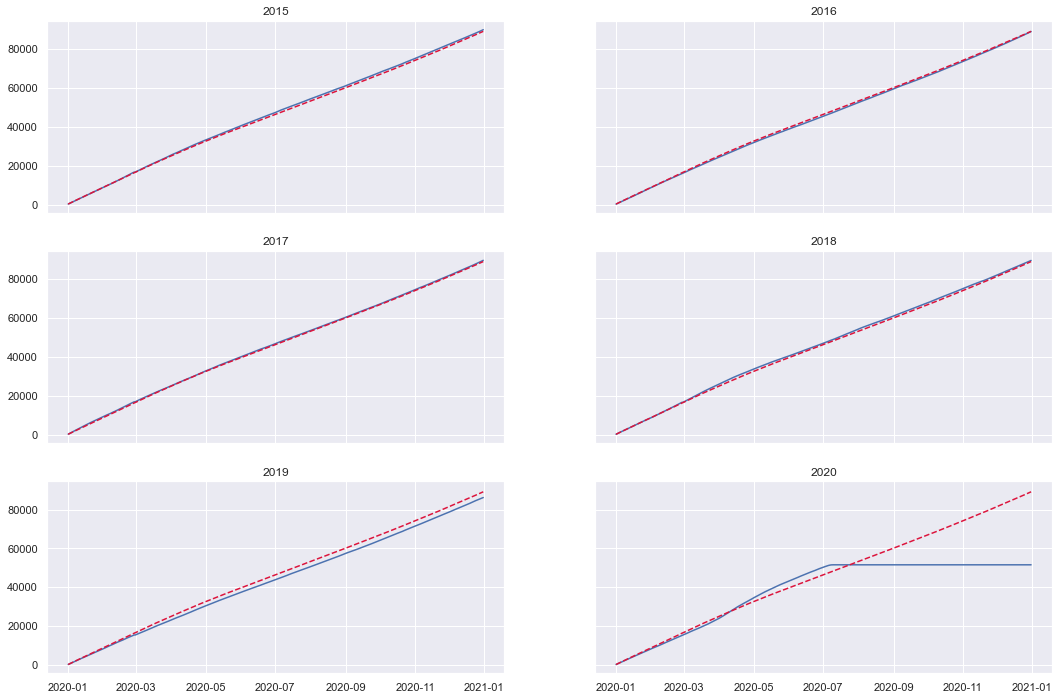

In [9]:
fig,axes = plt.subplots(3,2,sharex=True,sharey=True,figsize=(18,12))

axes[0,0].plot(df['2015'].cumsum())
axes[0,0].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[0,0].set_title('2015')

axes[0,1].plot(df['2016'].cumsum())
axes[0,1].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[0,1].set_title('2016')

axes[1,0].plot(df['2017'].cumsum())
axes[1,0].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[1,0].set_title('2017')

axes[1,1].plot(df['2018'].cumsum())
axes[1,1].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[1,1].set_title('2018')

axes[2,0].plot(df['2019'].cumsum())
axes[2,0].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[2,0].set_title('2019')

axes[2,1].plot(df['2020'].cumsum())
axes[2,1].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[2,1].set_title('2020')


In [10]:
df['excess_deaths'] = df['2020'] - df['2015-2019']

last_day = df[df['2020'] == 0].iloc[0].name.date()
last_day = last_day - pd.DateOffset(days=1)

print (last_day)

df_until_last_day = df.loc[:last_day].copy()
df_until_last_day['cum_excess'] = df_until_last_day['excess_deaths'].cumsum()
df_until_last_day.tail(30)

cumsums = df_until_last_day[['2015-2019','2020']].cumsum()
cumsums['delta'] = cumsums['2020'] - cumsums['2015-2019'] 
cumsums['delta_pct'] = cumsums['2020'] / cumsums['2015-2019'] 

cumsums.tail(20)

2020-07-10 00:00:00


,2015-2019,2020,delta,delta_pct
2020-06-21,44092,48004,3912,1.088724
2020-06-22,44311,48229,3918,1.088420
2020-06-23,44517,48442,3925,1.088169
2020-06-24,44739,48663,3924,1.087709
2020-06-25,44966,48912,3946,1.087755
2020-06-26,45192,49127,3935,1.087073
2020-06-27,45411,49369,3958,1.087159
2020-06-28,45629,49629,4000,1.087664
2020-06-29,45845,49820,3975,1.086705
2020-06-30,46067,50041,3974,1.086266


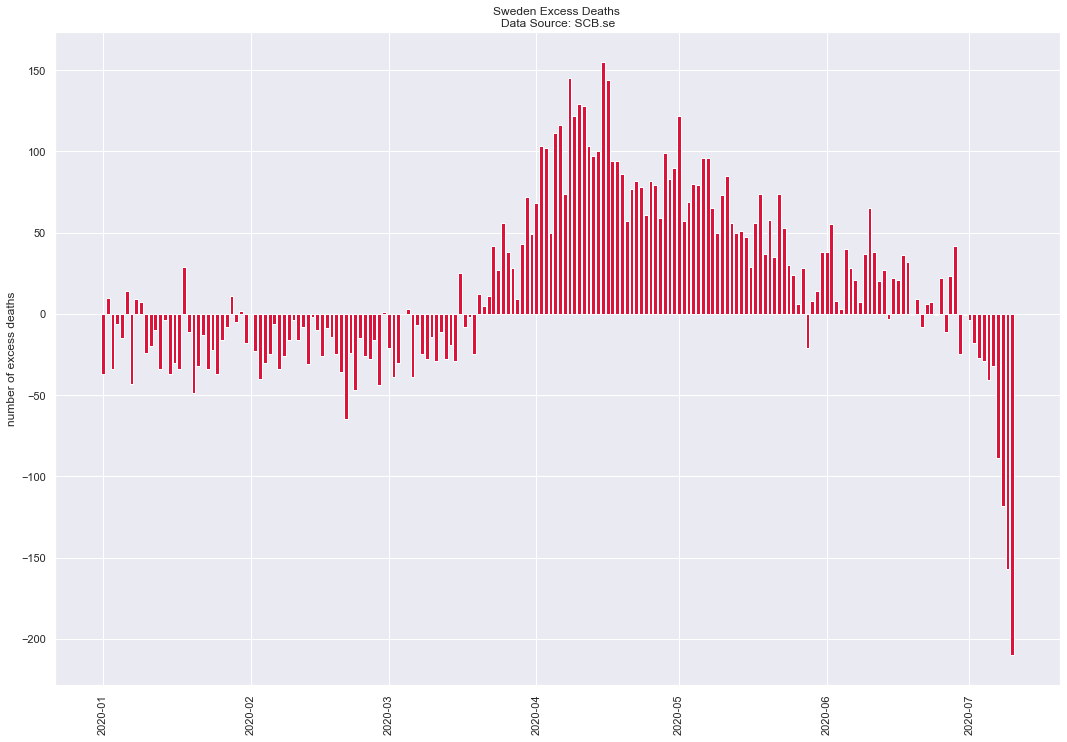

In [11]:
df_until_last_day.index = df_until_last_day.index.date
plt.figure(figsize=(18,12))
plt.title('Sweden Excess Deaths \nData Source: SCB.se')
plt.bar(df_until_last_day.index,df_until_last_day['excess_deaths'],color='crimson')
plt.xticks(rotation=90)
plt.ylabel('number of excess deaths')
plt.savefig('SCB_excess_daily_{}.jpg'.format(last_day.date()),format='jpg')

2020-05-12    2726
2020-05-13    2776
2020-05-14    2827
2020-05-15    2874
2020-05-16    2903
2020-05-17    2959
2020-05-18    3033
2020-05-19    3070
2020-05-20    3128
2020-05-21    3163
2020-05-22    3237
2020-05-23    3290
2020-05-24    3320
2020-05-25    3344
2020-05-26    3350
2020-05-27    3378
2020-05-28    3357
2020-05-29    3365
2020-05-30    3379
2020-05-31    3417
2020-06-01    3455
2020-06-02    3510
2020-06-03    3518
2020-06-04    3521
2020-06-05    3561
2020-06-06    3589
2020-06-07    3610
2020-06-08    3617
2020-06-09    3654
2020-06-10    3719
2020-06-11    3757
2020-06-12    3777
2020-06-13    3804
2020-06-14    3801
2020-06-15    3823
2020-06-16    3844
2020-06-17    3880
2020-06-18    3912
2020-06-19    3911
2020-06-20    3920
2020-06-21    3912
2020-06-22    3918
2020-06-23    3925
2020-06-24    3924
2020-06-25    3946
2020-06-26    3935
2020-06-27    3958
2020-06-28    4000
2020-06-29    3975
2020-06-30    3974
2020-07-01    3970
2020-07-02    3952
2020-07-03  

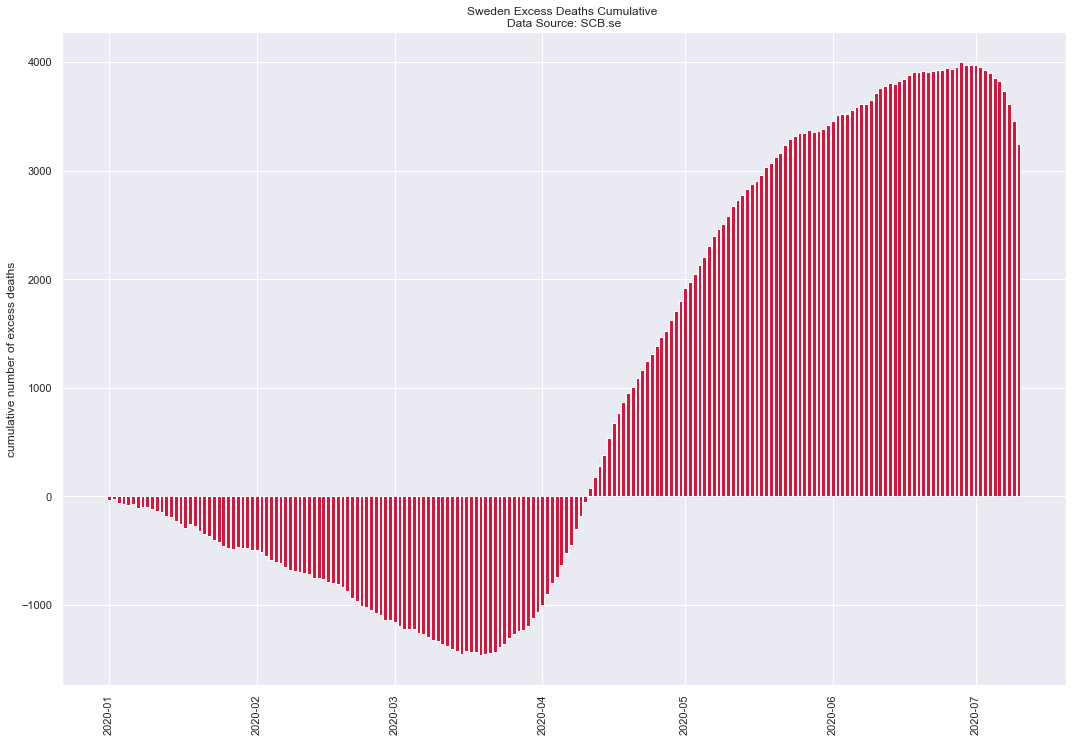

In [12]:
plt.figure(figsize=(18,12))
plt.title('Sweden Excess Deaths Cumulative \nData Source: SCB.se')
plt.bar(df_until_last_day.index,df_until_last_day['cum_excess'],color='crimson')
plt.xticks(rotation=90)
plt.ylabel('cumulative number of excess deaths')
print (df_until_last_day['cum_excess'].tail(60))
plt.savefig('SCB_excess_daily_cumsum_{}.jpg'.format(last_day.date()),format='jpg')

In [13]:
df_until_last_day.index = pd.to_datetime(df_until_last_day.index)

### skip the last 7 days since they are likely to be updated ### 

last_week = df_until_last_day.index[-1] - pd.DateOffset(weeks=1)
last_week = last_week.date()

until_last_week = df_until_last_day[:last_week]
until_last_week.tail(40)

weekly = until_last_week['excess_deaths'].resample('W').sum()
weekly

2020-01-05    -82
2020-01-12    -67
2020-01-19   -121
2020-01-26   -203
2020-02-02    -41
2020-02-09   -177
2020-02-16    -97
2020-02-23   -220
2020-03-01   -149
2020-03-08   -137
2020-03-15   -158
2020-03-22     18
2020-03-29    243
2020-04-05    555
2020-04-12    817
2020-04-19    770
2020-04-26    516
2020-05-03    579
2020-05-10    539
2020-05-17    374
2020-05-24    361
2020-05-31     97
2020-06-07    193
2020-06-14    191
2020-06-21    111
2020-06-28     88
2020-07-05    -75
Freq: W-SUN, Name: excess_deaths, dtype: int64

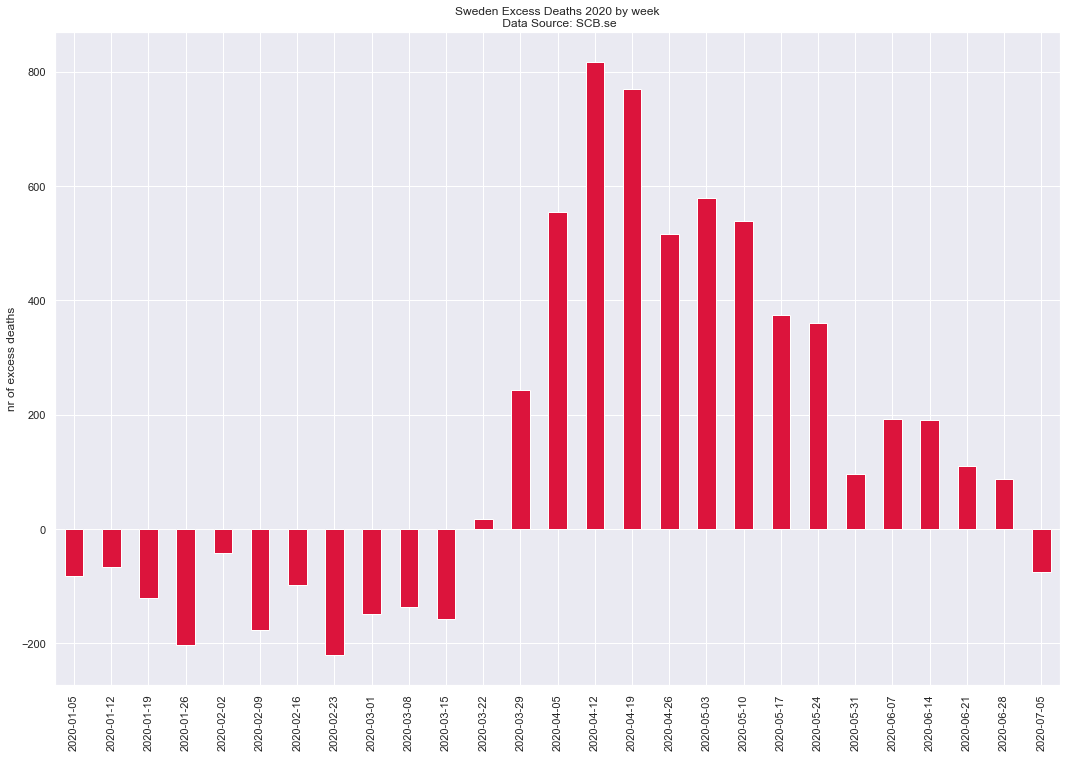

In [14]:
#plt.figure(figsize=(18,12))
#plt.bar(weekly.index,weekly,color='crimson')
weekly.index = weekly.index.date
weekly.plot.bar(figsize=(18,12),color='crimson',title='Sweden Excess Deaths 2020 by week\n Data Source: SCB.se')
plt.ylabel('nr of excess deaths')
plt.savefig('SCB_excess_weekly_{}.jpg'.format(last_day.date()),format='jpg')


2020-01-05     -82
2020-01-12    -149
2020-01-19    -270
2020-01-26    -473
2020-02-02    -514
2020-02-09    -691
2020-02-16    -788
2020-02-23   -1008
2020-03-01   -1157
2020-03-08   -1294
2020-03-15   -1452
2020-03-22   -1434
2020-03-29   -1191
2020-04-05    -636
2020-04-12     181
2020-04-19     951
2020-04-26    1467
2020-05-03    2046
2020-05-10    2585
2020-05-17    2959
2020-05-24    3320
2020-05-31    3417
2020-06-07    3610
2020-06-14    3801
2020-06-21    3912
2020-06-28    4000
2020-07-05    3925
Name: excess_deaths, dtype: int64


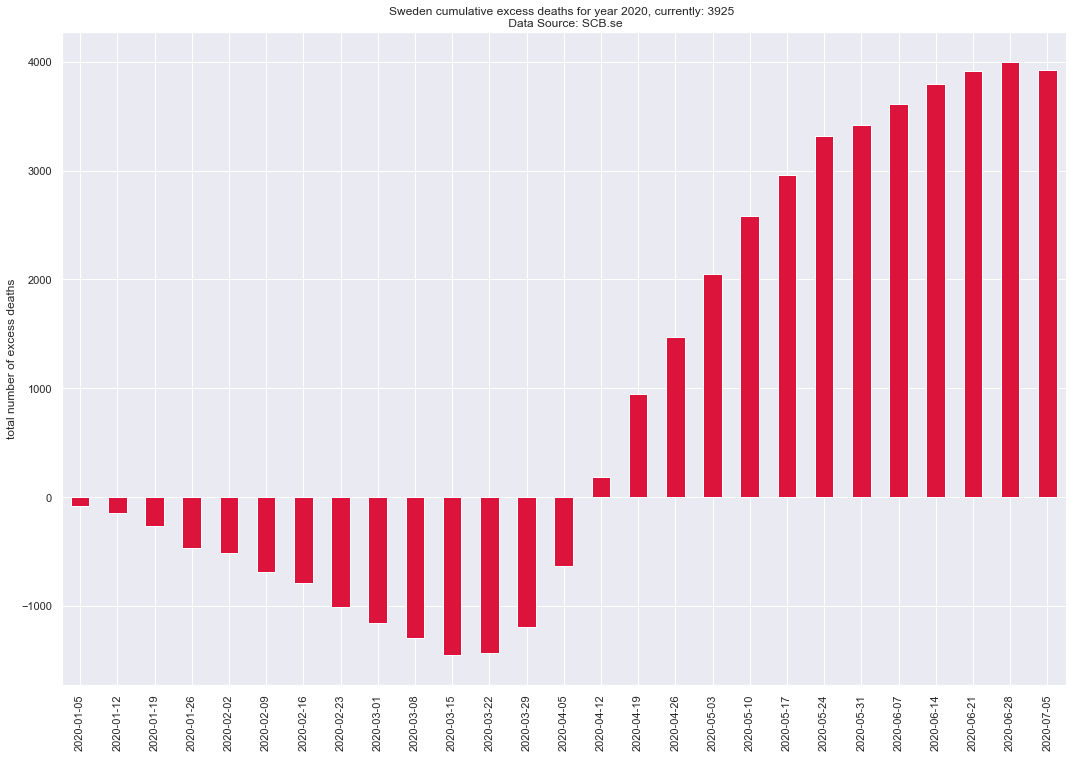

In [15]:
latest = weekly.cumsum()[-1]
weekly.cumsum().plot.bar(figsize=(18,12),color='crimson',
                         title='Sweden cumulative excess deaths for year 2020, currently: {} \n Data Source: SCB.se'.format(latest))
print (weekly.cumsum())
plt.ylabel('total number of excess deaths')
plt.savefig('SCB_excess_weekly_cumsum_{}.jpg'.format(last_day.date()),format='jpg')


In [16]:
df

,DagMånad,2015,2016,2017,2018,2019,2020,2015-2019,excess_deaths
2020-01-01,1 januari,295,245,339,275,300,254,291,-37
2020-01-02,2 januari,272,272,317,312,276,300,290,10
2020-01-03,3 januari,281,293,310,295,271,256,290,-34
2020-01-04,4 januari,256,260,305,285,282,272,278,-6
2020-01-05,5 januari,268,260,304,291,275,265,280,-15
...,...,...,...,...,...,...,...,...,...
2020-12-27,27 december,227,249,271,240,238,0,245,-245
2020-12-28,28 december,274,262,273,261,215,0,257,-257
2020-12-29,29 december,292,274,276,263,244,0,270,-270
2020-12-30,30 december,283,307,275,232,226,0,265,-265


In [17]:
# 2019 flu season

df['excess_2019'] = df['2019'] - df['2015-2019']
df

,DagMånad,2015,2016,2017,2018,2019,2020,2015-2019,excess_deaths,excess_2019
2020-01-01,1 januari,295,245,339,275,300,254,291,-37,9
2020-01-02,2 januari,272,272,317,312,276,300,290,10,-14
2020-01-03,3 januari,281,293,310,295,271,256,290,-34,-19
2020-01-04,4 januari,256,260,305,285,282,272,278,-6,4
2020-01-05,5 januari,268,260,304,291,275,265,280,-15,-5
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,27 december,227,249,271,240,238,0,245,-245,-7
2020-12-28,28 december,274,262,273,261,215,0,257,-257,-42
2020-12-29,29 december,292,274,276,263,244,0,270,-270,-26
2020-12-30,30 december,283,307,275,232,226,0,265,-265,-39


In [18]:
df.sum()

DagMånad         1 januari2 januari3 januari4 januari5 januari6...
2015                                                         89947
2016                                                         89019
2017                                                         89742
2018                                                         89672
2019                                                         86150
2020                                                         51557
2015-2019                                                    89105
excess_deaths                                               -37548
excess_2019                                                  -2955
dtype: object

In [19]:
df_weekly = df.resample('W').sum()
df_weekly['2020_cum'] = df_weekly['excess_deaths'].cumsum()
df_weekly['2019_cum'] = df_weekly['excess_2019'].cumsum()
df_weekly.index = df_weekly.index - pd.DateOffset(years=1)

df_weekly

,2015,2016,2017,2018,2019,2020,2015-2019,excess_deaths,excess_2019,2020_cum,2019_cum
2019-01-05,1372,1330,1575,1458,1404,1347,1429,-82,-25,-82,-25
2019-01-12,1985,1911,2125,1913,1847,1890,1957,-67,-110,-149,-135
2019-01-19,1923,1894,2113,1970,1833,1827,1948,-121,-115,-270,-250
2019-01-26,1932,2000,1959,1918,1855,1730,1933,-203,-78,-473,-328
2019-02-02,1993,1925,1915,1849,1755,1847,1888,-41,-133,-514,-461
2019-02-09,1870,1938,1857,1956,1890,1726,1903,-177,-13,-691,-474
2019-02-16,2016,1802,1915,2065,1818,1826,1923,-97,-105,-788,-579
2019-02-23,2104,1859,2108,2089,1810,1774,1994,-220,-184,-1008,-763
2019-03-01,1783,1792,1727,1841,1524,1778,1927,-149,-403,-1157,-1166
2019-03-08,2041,1928,1934,2212,1698,1825,1962,-137,-264,-1294,-1430


Text(0.5, 1.0, 'Excess deaths 2019')

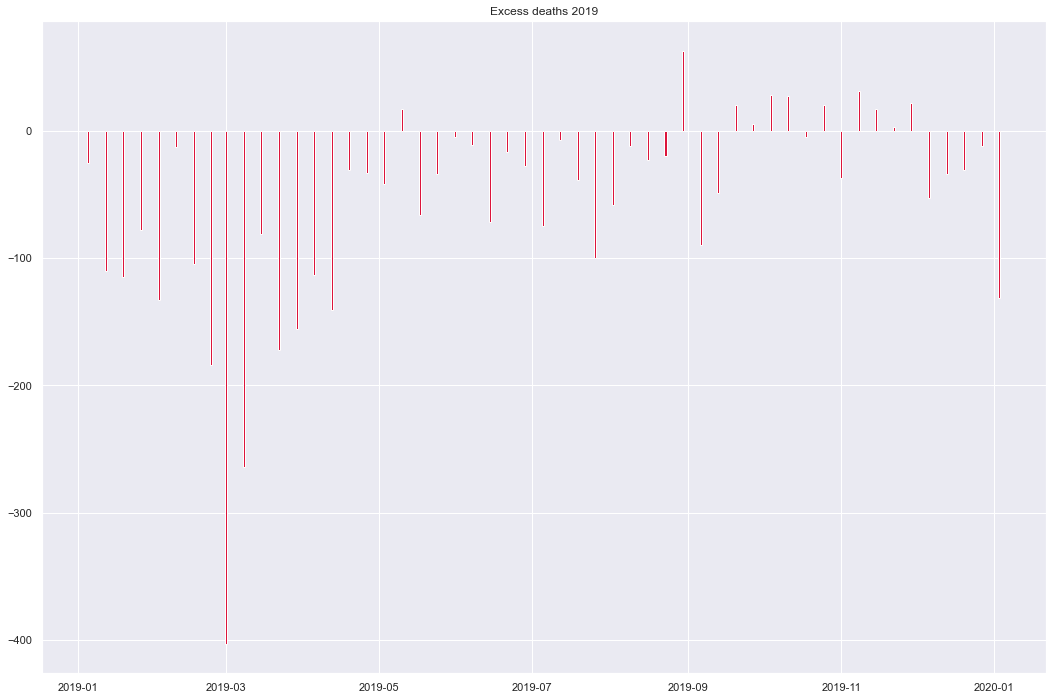

In [20]:
plt.figure(figsize=(18,12))
plt.bar(df_weekly.index,df_weekly['excess_2019'],color='crimson')
plt.title('Excess deaths 2019')

Text(0.5, 1.0, '2019 Excess Deaths Cumulative')

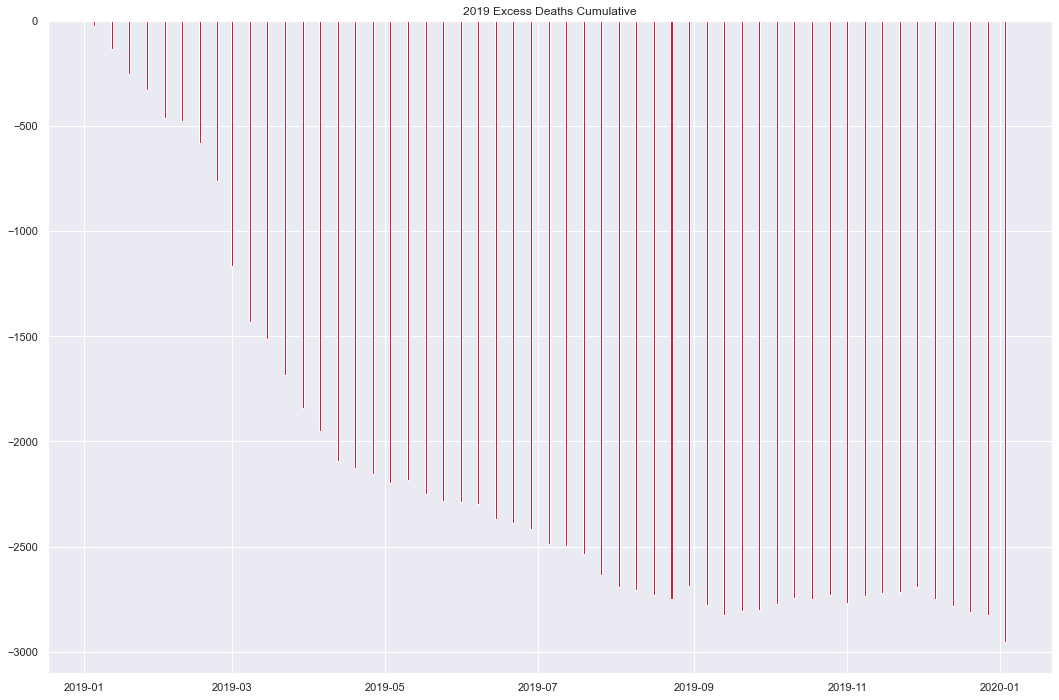

In [21]:
plt.figure(figsize=(18,12))
plt.bar(df_weekly.index,df_weekly['2019_cum'],color='crimson')
plt.title('2019 Excess Deaths Cumulative')

In [22]:
df

,DagMånad,2015,2016,2017,2018,2019,2020,2015-2019,excess_deaths,excess_2019
2020-01-01,1 januari,295,245,339,275,300,254,291,-37,9
2020-01-02,2 januari,272,272,317,312,276,300,290,10,-14
2020-01-03,3 januari,281,293,310,295,271,256,290,-34,-19
2020-01-04,4 januari,256,260,305,285,282,272,278,-6,4
2020-01-05,5 januari,268,260,304,291,275,265,280,-15,-5
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,27 december,227,249,271,240,238,0,245,-245,-7
2020-12-28,28 december,274,262,273,261,215,0,257,-257,-42
2020-12-29,29 december,292,274,276,263,244,0,270,-270,-26
2020-12-30,30 december,283,307,275,232,226,0,265,-265,-39


In [23]:
print(df.loc['2020-10-01':,'excess_2019'].sum())
df.loc[:'2020-05-15',['excess_deaths','excess_2019']].sum()

-182


excess_deaths    2874
excess_2019     -2219
dtype: int64

In [24]:
start_day = '2020-06-01' # back 7 days to get stable data from scb
start_period = pd.Timestamp(start_day)


df_19_2h = df.loc[start_period :,'2019']
df_19_2h.index = pd.date_range(start_period - pd.DateOffset(years=1),'2019-12-31')

dayname = df_19_2h.index[0].day_name()

df_20_1h = df.loc['2020-01-01' : start_period - pd.DateOffset(days=1),'2020']
print (df_20_1h)

df_19_20 = pd.concat([df_19_2h,df_20_1h])
df_19_20.sum()

2020-01-01    254
2020-01-02    300
2020-01-03    256
2020-01-04    272
2020-01-05    265
             ... 
2020-05-27    244
2020-05-28    216
2020-05-29    230
2020-05-30    241
2020-05-31    256
Freq: D, Name: 2020, Length: 152, dtype: int64


91854

In [25]:
df_baseline_1h = df.loc[start_period :,'2015-2019']
df_baseline_1h.index = pd.date_range(start_period - pd.DateOffset(years=1),'2019-12-31')
df_baseline_2h = df.loc[:start_period - pd.DateOffset(days=1),'2015-2019']

df_baseline = pd.concat([df_baseline_1h,df_baseline_2h])
(df_19_20 - df_baseline).sum()

2749

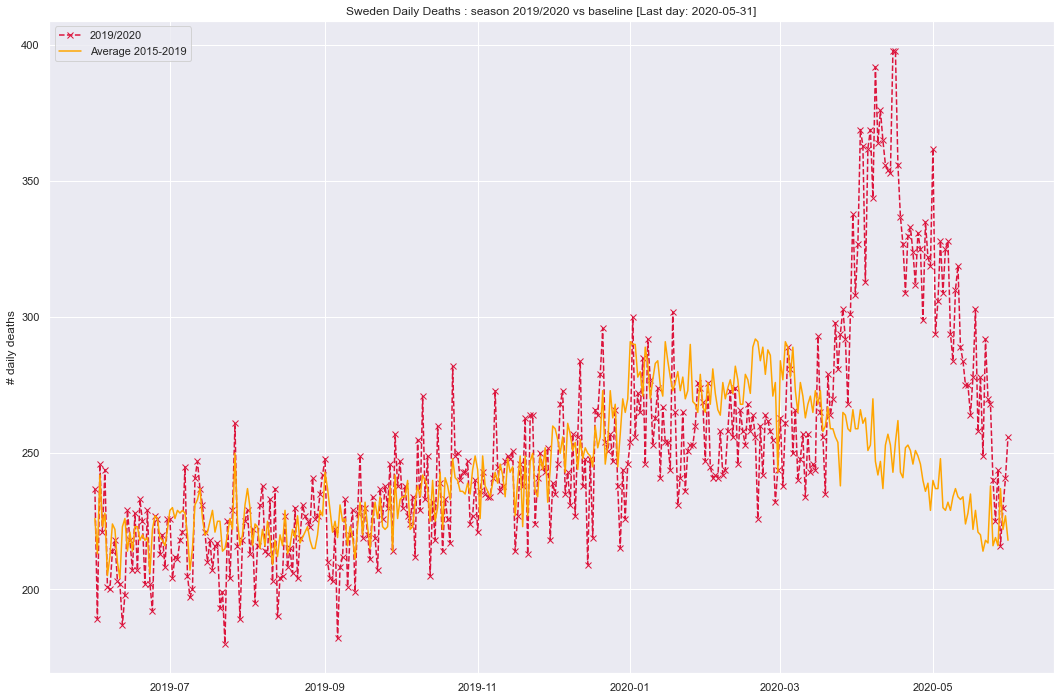

In [26]:
last_day = df_19_20.index[-1].date()
plt.figure(figsize=(18,12))
plt.title('Sweden Daily Deaths : season 2019/2020 vs baseline [Last day: {}]'.format(last_day))
plt.plot(df_19_20,'x--',color='crimson',label='2019/2020')
plt.plot(df_baseline,color='orange',label='Average 2015-2019')
plt.ylabel('# daily deaths')
plt.legend(loc='upper left')
plt.savefig('SCB_season_19_20.jpg',format='jpg')

2749


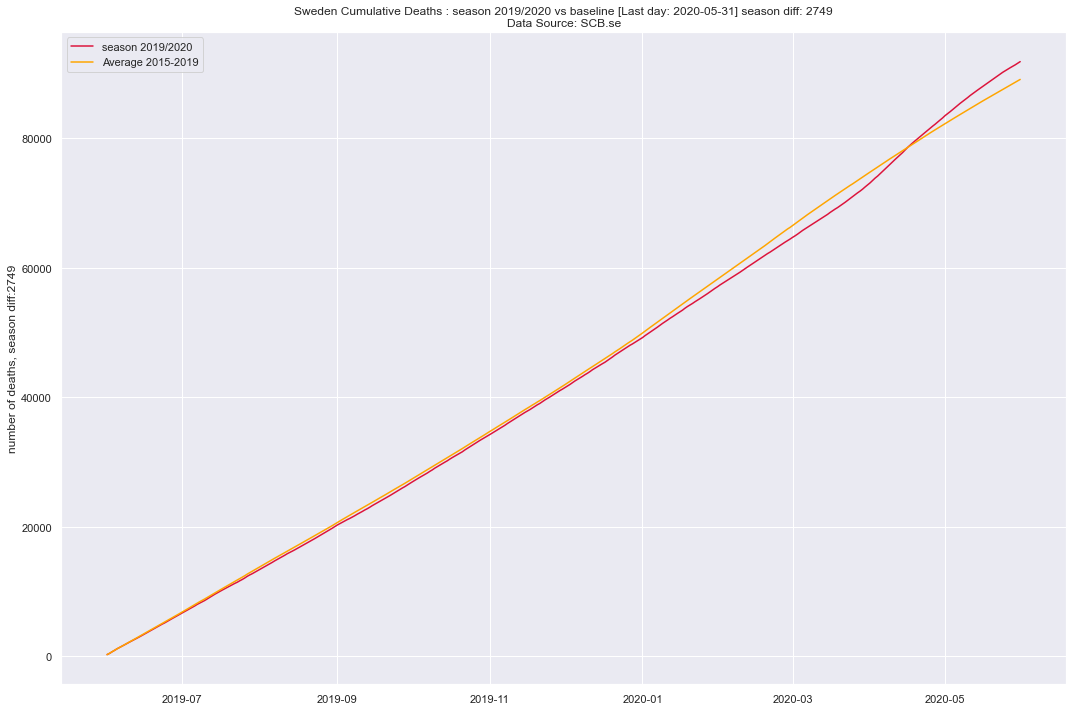

In [27]:
season_diff = df_19_20.sum() - df_baseline.sum()
print (season_diff)
plt.figure(figsize=(18,12))
plt.title('Sweden Cumulative Deaths : season 2019/2020 vs baseline [Last day: {}] season diff: {}\nData Source: SCB.se'.format(last_day,season_diff))
plt.plot(df_19_20.cumsum(),color='crimson',label='season 2019/2020')
plt.plot(df_baseline.cumsum(),color='orange',label='Average 2015-2019')
plt.legend(loc='upper left')
plt.ylabel('number of deaths, season diff:{}'.format(df_19_20.sum() - df_baseline.sum()))
plt.savefig('SCB_season_19_20_cumulative.jpg',format='jpg')

In [28]:
print ('startday in 2019 calendar:',dayname)
previous_day = df_19_20.index[0] - pd.DateOffset(days=1)
print ('previous day:',previous_day)
day_code = 'W-' + previous_day.day_name()[:3].upper()
print (day_code)
df_weekly_19_20 = df_19_20.resample(day_code,convention='end').sum()
df_weekly_baseline = df_baseline.resample(day_code,convention='end').sum()
df_weekly_19_20.tail(40)

startday in 2019 calendar: Saturday
previous day: 2019-05-31 00:00:00
W-FRI


2019-09-06    1511
2019-09-13    1502
2019-09-20    1591
2019-09-27    1603
2019-10-04    1651
2019-10-11    1658
2019-10-18    1617
2019-10-25    1697
2019-11-01    1645
2019-11-08    1696
2019-11-15    1714
2019-11-22    1665
2019-11-29    1719
2019-12-06    1714
2019-12-13    1736
2019-12-20    1733
2019-12-27    1809
2020-01-03    1741
2020-01-10    1890
2020-01-17    1797
2020-01-24    1791
2020-01-31    1832
2020-02-07    1745
2020-02-14    1817
2020-02-21    1783
2020-02-28    1773
2020-03-06    1826
2020-03-13    1745
2020-03-20    1818
2020-03-27    2002
2020-04-03    2274
2020-04-10    2520
2020-04-17    2580
2020-04-24    2272
2020-05-01    2293
2020-05-08    2184
2020-05-15    2036
2020-05-22    1922
2020-05-29    1693
2020-06-05     497
Freq: W-FRI, dtype: int64

In [29]:
#flu season

flu_baseline = df_baseline.loc['2019-12-01' : '2020-03-31']
flu_19_20 = df_19_20.loc['2019-12-01' : '2020-03-31']
print (flu_baseline.sum())
print (flu_19_20.sum())

flu = flu_19_20.sum() - flu_baseline.sum()
print (flu)

end_period = start_period - pd.DateOffset(days=1)
corona_baseline = df_baseline.loc['2020-04-01' : end_period].sum()
corona_19_20 = df_19_20.loc['2020-04-01' : end_period].sum()

corona = corona_19_20 - corona_baseline
print (corona)

32854
31549
-1305
4487


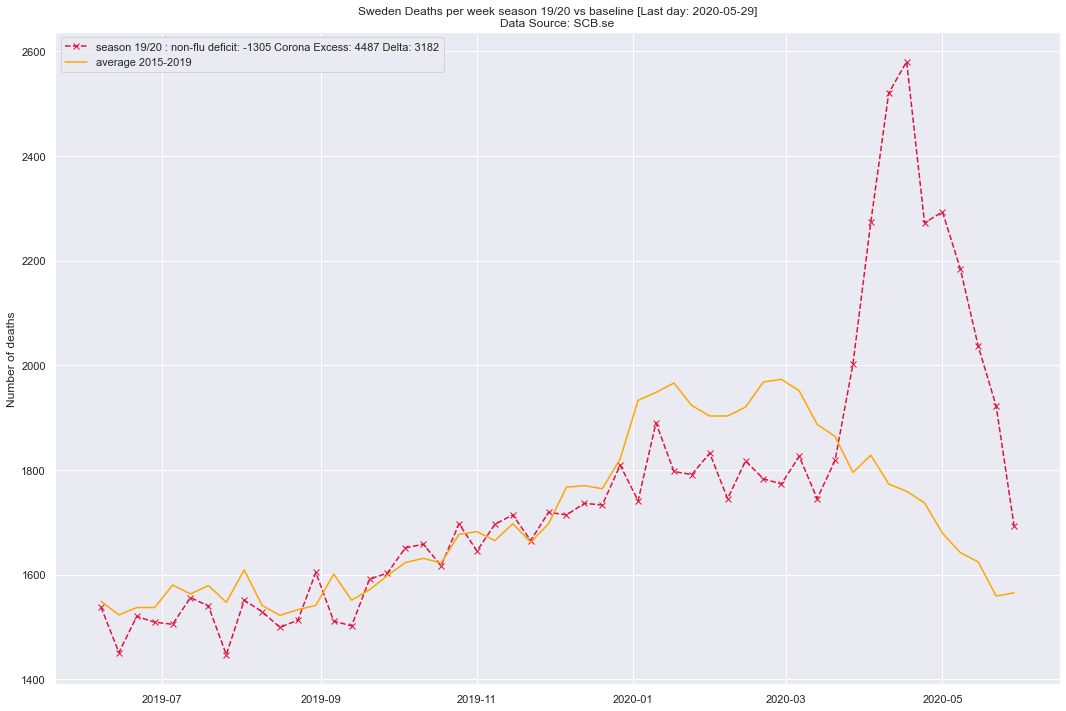

In [30]:
#note cut of last incomplete week
last_day = df_weekly_19_20.index[-2].date()

plt.figure(figsize=(18,12))
plt.title('Sweden Deaths per week season 19/20 vs baseline [Last day: {}]\nData Source: SCB.se'.format(last_day))
plt.ylabel('Number of deaths')
plt.plot(df_weekly_19_20[:-1],
         'x--',color='crimson',
         label='season 19/20 : non-flu deficit: {} Corona Excess: {} Delta: {}'.format(flu,corona,corona+flu))
plt.plot(df_weekly_baseline[:-1],color='orange',label='average 2015-2019')
plt.legend(loc='upper left')
plt.savefig('SCB_season_19_20_weekly.jpg',format='jpg')

2019-06-30     6452
2019-07-31     6723
2019-08-31     6829
2019-09-30     6674
2019-10-31     7338
2019-11-30     7233
2019-12-31     7705
2020-01-31     8120
2020-02-29     7362
2020-03-31     8362
2020-04-30    10362
2020-05-31     8694
Freq: M, dtype: int64
2019-06-30    6584
2019-07-31    6973
2019-08-31    6831
2019-09-30    6776
2019-10-31    7309
2019-11-30    7209
2019-12-31    7940
2020-01-31    8611
2020-02-29    8007
2020-03-31    8296
2020-04-30    7494
2020-05-31    7075
Freq: M, Name: 2015-2019, dtype: int64
2019-06-30    -132
2019-07-31    -250
2019-08-31      -2
2019-09-30    -102
2019-10-31      29
2019-11-30      24
2019-12-31    -235
2020-01-31    -491
2020-02-29    -645
2020-03-31      66
2020-04-30    2868
2020-05-31    1619
Freq: M, dtype: int64


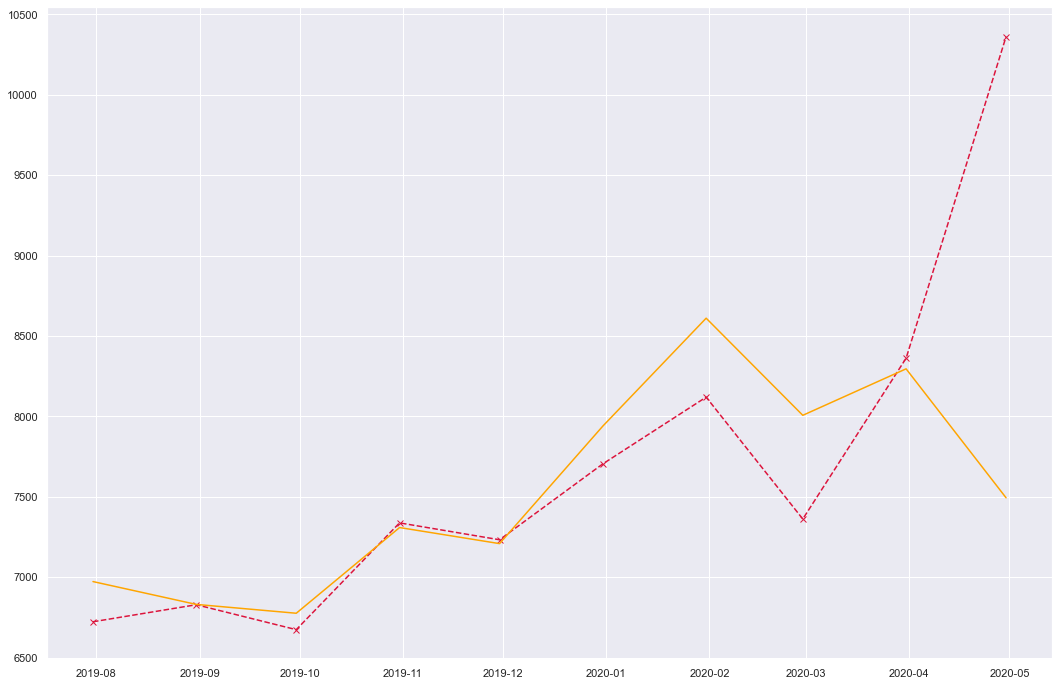

In [31]:
df_monthly_19_20 = df_19_20.resample('M').sum()
df_monthly_baseline = df_baseline.resample('M').sum()
print (df_monthly_19_20)
print (df_monthly_baseline)
print (df_monthly_19_20 - df_monthly_baseline)

plt.figure(figsize=(18,12))
plt.plot(df_monthly_19_20[1:-1],'x--',color='crimson')
plt.plot(df_monthly_baseline[1:-1],color='orange')